1. Read in all of the predicted (major topic) congress speech data (from multiple files. keep just party, cong_number, text, date, topic)
2. Keep only rows where party == democrat or republican 
3. Partition the data by major topic. 
4. Chunk into 2.5k character length rows
5. Tokenize:
	a. Remove Roberts Rules tokens
	b. Keep only tokens in the news data
	c. Only tokens that appear in 10 documents or more
6. Within each topic, predict party. Use Elastic Net. 
7. This will give you 21 models --- one for each topic
8. Output classification success of each.
9. Output top 20 Republican and Democrat words for each model.

### Update

1. May be the first thing to do with the news bigram/trigram data is to only keep bigrams/trigrams that appear in at least 100 articles.

### Update

When we are subetting the news data, we should limit bigrams that appear in 100 or more documents (for now) and trigrams that appear in 10 or more documents (for now). I think that is a good catch.



In [1]:
import pandas as pd
import numpy as np
import time

In [2]:
import nltk
from nltk import word_tokenize          
from nltk.stem.porter import PorterStemmer
import re
import string

stemmer = PorterStemmer()
def stem_tokens(tokens, stemmer):
    stemmed = []
    for item in tokens:
        stemmed.append(stemmer.stem(item))
    return stemmed

#def tokenize(text):
#    tokens = nltk.word_tokenize(text)
#    stems = stem_tokens(tokens, stemmer)
#    return stems

def tokenize(text):
    text = "".join([ch for ch in text if ch not in string.punctuation])
    tokens = nltk.word_tokenize(text)
    stems = stem_tokens(tokens, stemmer)
    return stems

%matplotlib inline
import matplotlib.pyplot as plt
from pandas_confusion import ConfusionMatrix
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn import svm
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.cross_validation import train_test_split

with open('../roberts_rules/all_text.txt', 'rt') as f:
    text = f.read()
text = text.decode('ascii', 'ignore')
text = re.sub(r'\d+', '', text)

vect = CountVectorizer(tokenizer=tokenize, stop_words='english', ngram_range=(2, 3)) 
vect.fit([text])
roberts_rules = set(vect.get_feature_names())

def most_informative_feature_for_class(vectorizer, classifier, classlabel, n=10):
    labelid = list(classifier.classes_).index(classlabel)
    feature_names = vectorizer.get_feature_names()
    topn = sorted(zip(classifier.coef_[labelid], feature_names))[-n:]

    for coef, feat in topn:
        print classlabel, feat, coef

def most_informative_feature_for_class_svm(vectorizer, classifier,  n=10):
    labelid = 3 # this is the coef we're interested in. 
    feature_names = vectorizer.get_feature_names()
    svm_coef = classifier.coef_.toarray() 
    topn = sorted(zip(svm_coef[labelid], feature_names))[-n:]

    for coef, feat in topn:
        print feat, coef

def print_top10(vectorizer, clf, class_labels):
    """Prints features with the highest coefficient values, per class"""
    feature_names = vectorizer.get_feature_names()
    for i, class_label in enumerate(class_labels):
        top10 = np.argsort(clf.coef_[i])[-10:]
        print("%s: %s" % (class_label,
              " | ".join(feature_names[j] for j in top10)))

def get_top_features(vectorizer, clf, class_labels, n=20):
    """Prints features with the highest coefficient values, per class"""
    feature_names = vectorizer.get_feature_names()
    top_features = {}
    for i, class_label in enumerate(class_labels):
        topN = np.argsort(clf.coef_[i])[-n:]
        top_features[class_label] = [feature_names[j] for j in topN][::-1]
    return top_features

def show_most_informative_features(vectorizer, clf, n=20):
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(clf.coef_[0], feature_names))
    top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        print "\t%.4f\t%-20s\t\t%.4f\t%-20s" % (coef_1, fn_1, coef_2, fn_2)

## Read Predicted Congress dataset

In [3]:
adf = None
for nth in range(107, 113):
    print nth
    df = pd.read_csv('../data/congress_%d_predict_major_label.csv' % nth) #, nrows=10)
    if adf is None:
        adf = df
    else:
        adf = pd.concat([adf, df])
adf

107
108
109
110
111
112


,date,text,party,topic,cong_number
0,2002-03-19,mr speaker yield minut gentleman virginia mr m...,100,20,107
1,2002-11-19,mr speaker would like submit appropri congress...,100,21,107
2,2002-06-06,mr speaker yesterday flight lo angel delay dep...,100,1,107
3,2002-03-06,mr speaker earlier today unabl cast vote two r...,100,3,107
4,2002-04-16,mr speaker thank gentleman yield time mr speak...,100,20,107
5,2002-10-01,mr speaker yield minut gentlewoman new york ms...,100,15,107
6,2001-10-16,mr speaker friday octob unavoid miss two roll ...,100,7,107
7,2002-05-09,mr chairman although disappoint rule bodi rise...,100,16,107
8,2002-10-01,mr speaker yield minut gentlewoman texa ms edd...,100,19,107
9,2002-10-01,mr speaker yield minut gentleman new jersey mr...,100,20,107


In [4]:
df = df[df.party.isin([100, 200])]

## Split long bill to smaller chunk (2500 chars)

In [5]:
import re
import textwrap

def insert_chars_split_marker(text, cc=2500):
    # FIXME: text still has number
    text = re.sub('\d+', '', text)
    out = '|'.join(textwrap.wrap(text, cc))
    return out

def insert_words_split_marker(text, wc=500):
    text = re.sub('\d+', '', text)
    words = text.split()
    out = ''
    for i, w in enumerate(words):
        if i != 0 and i % wc == 0:
            out += '|' + w
        else:
            out += ' ' + w
    return out

In [6]:
def remove_roberts_rules(all_vocab):
    vocab = []
    i = 0
    for a in all_vocab:
        if a not in roberts_rules:
            vocab.append(a)
        else:
            #print a
            i += 1
    print("Removed {0:d}".format(i))
    print("Total {0:d}".format(len(vocab)))
    return vocab


In [7]:
for t in df.topic.unique():
    if t != 5:
        continue
    sdf = df[df.topic == t]
    print t, len(sdf)
    
    if True:
        # split long text to multiple rows
        sdf.loc[:, 'text'] = sdf.text.astype(str).apply(lambda c: insert_chars_split_marker(c, 2500))
        s = sdf['text'].str.split('|', expand=True).stack()
        i = s.index.get_level_values(0)
        new_df = sdf.loc[i].copy()
        new_df['chunk'] = s.index.get_level_values(1)
        new_df['text'] = s.values
        sdf = new_df.reset_index(drop=True)
    
    print t, len(sdf)
    vect = CountVectorizer(ngram_range=(2, 3), min_df=10) 
    vect.fit(sdf.text)
    print len(vect.get_feature_names())
    
    vocab = remove_roberts_rules(vect.vocabulary_)
    print len(vocab)

    new_vocab = []
    ng = pd.read_csv('../data/major_%s_news_2gram_df100.csv' % t)
    for v in vocab:
        if v in ng.ngram.tolist():
            new_vocab.append(v)
    ng = pd.read_csv('../data/major_%s_news_3gram_df10.csv' % t)
    for v in vocab:
        if v in ng.ngram.tolist():
            new_vocab.append(v)
    break

5 1326


/opt/venv/local/lib/python2.7/site-packages/pandas/core/indexing.py:465: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


5 1745
2421
Removed 97
Total 2324
2324


In [8]:
len(new_vocab)

1901

In [9]:
ng_df = pd.DataFrame(new_vocab)
ng_df.columns = ['ngram']
ng_df

,ngram
0,american compani
1,throughout histori
2,job fact
3,day work
4,presid georg
5,work us
6,could get
7,cut payrol
8,histori countri
9,presid job


In [10]:
ng_df.to_csv('../data/major_%d_congress_23gram_new.csv' % t, index=False)

## Model (Party)

In [397]:
X = sdf.text
y = sdf.party

X_train,  X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [398]:
#vect = CountVectorizer(ngram_range=(2, 3), min_df=20, vocabulary=vocab)
vect = CountVectorizer(ngram_range=(2, 3), min_df=10, vocabulary=new_vocab)

In [399]:
X_train = vect.transform(X_train)
transformer = TfidfTransformer()
X_train = transformer.fit_transform(X_train)

In [400]:
X_test = vect.transform(X_test)
transformer = TfidfTransformer()
X_test = transformer.fit_transform(X_test)

In [401]:
from sklearn.linear_model import SGDClassifier

elastic_clf = SGDClassifier(loss='log', alpha=.0001, n_iter=100, penalty="elasticnet")
t0 = time.time()
elastic_clf.fit(X_train, y_train)
t1 = time.time()
prediction_elastic = elastic_clf.predict(X_test)
t2 = time.time()
time_elastic_train = t1-t0
time_elastic_predict = t2-t1

print("Results for Elastic Net")
print("Training time: %fs; Prediction time: %fs" % (time_elastic_train, time_elastic_predict))
print(classification_report(y_test, prediction_elastic))

Results for Elastic Net
Training time: 0.071542s; Prediction time: 0.000362s
             precision    recall  f1-score   support

        100       0.82      0.91      0.86       218
        200       0.82      0.66      0.73       131

avg / total       0.82      0.82      0.81       349



In [402]:
most_informative_feature_for_class(vect, elastic_clf, 100)

100 full year 2.99541799506
100 presid said 3.16227074459
100 citizen unit state 3.3148658527
100 rule law 3.44424507983
100 amend would 3.4658876955
100 feder govern 3.70804356482
100 pass bill 4.30166276967
100 job creator 4.39371826708
100 south carolina 4.70604297503
100 illeg alien 5.02008126925


In [403]:
show_most_informative_features(vect, elastic_clf, 20)

	-4.4533	tax cut             		5.0201	illeg alien         
	-4.2739	dream act           		4.7060	south carolina      
	-4.0929	republican colleagu 		4.3937	job creator         
	-3.9378	make america        		4.3017	pass bill           
	-3.5423	american job act    		3.7080	feder govern        
	-3.5274	republican leader   		3.4659	amend would         
	-3.5094	middl class         		3.4442	rule law            
	-3.2409	role model          		3.3149	citizen unit state  
	-3.0222	famili member       		3.1623	presid said         
	-2.9672	lost live           		2.9954	full year           
	-2.8963	human right         		2.7285	nt need             
	-2.7081	tax credit          		2.6936	allow employ        
	-2.7042	local commun        		2.6727	unit state congress 
	-2.6471	million peopl       		2.6710	common ground       
	-2.5890	help peopl          		2.6584	border secur        
	-2.5713	worker protect      		2.6511	nt take             
	-2.5430	thousand american   		2.6400	drug cartel       

In [404]:
def get_most_informative_features(vectorizer, clf, n=20):
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(clf.coef_[0], feature_names))
    top_a = coefs_with_fns[:n]
    top_b = coefs_with_fns[:-(n + 1):-1]
    return top_a, top_b

top_a, top_b = get_most_informative_features(vect, elastic_clf, 20)
top_a_df = pd.DataFrame(top_a)
top_a_df.columns = ['coef', 'term']
top_b_df = pd.DataFrame(top_b)
top_b_df.columns = ['coef', 'term']
top_a_df.to_csv('../data/major_%s_top20_rep_new.csv' % t, index=False)
top_b_df.to_csv('../data/major_%s_top20_dem_new.csv' % t, index=False)

In [405]:
from sklearn.externals import joblib

joblib.dump(vect, "../models/major_%s_vec_count_cong_23gram_new.joblib" % t)
joblib.dump(elastic_clf, "../models/major_%s_cong_clf_elastic_new.joblib" % t)

['../models/major_5_cong_clf_elastic_new2.joblib',
 '../models/major_5_cong_clf_elastic_new2.joblib_01.npy',
 '../models/major_5_cong_clf_elastic_new2.joblib_02.npy',
 '../models/major_5_cong_clf_elastic_new2.joblib_03.npy',
 '../models/major_5_cong_clf_elastic_new2.joblib_04.npy']

In [406]:
y_test_df = pd.DataFrame(y_test).reset_index(drop=True)
y_test_df['predicted'] = prediction_elastic
y_test_df.to_csv('../data/major_%s_test_prediction_party_new.csv' % t, index=False)

In [407]:
y_true = y_test.reset_index(drop=True)
confusion_matrix = ConfusionMatrix(y_true, prediction_elastic)
print("Confusion matrix:\n%s" % confusion_matrix)

Confusion matrix:
Predicted  100  200  __all__
Actual                      
100        199   19      218
200         45   86      131
__all__    244  105      349


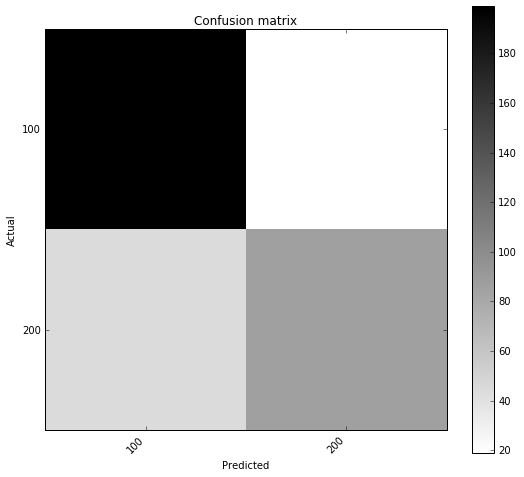

In [408]:
confusion_matrix.plot()

In [409]:
from sklearn.metrics import confusion_matrix
conf = confusion_matrix(y_true, prediction_elastic)
conf_df = pd.DataFrame(conf)
conf_df.columns = elastic_clf.classes_
conf_df.index = elastic_clf.classes_
conf_df.to_csv('../data/major_%s_test_confusion_matrix_party_new.csv' % t, index_label="actual \ predicted")
conf_df

,100,200
100,199,19
200,45,86
